In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/深度學習期末/archive/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/"
img_dir = os.path.join(data_dir, "All_img/")
train_csv = os.path.join(data_dir, "train_data.csv")
val_csv = os.path.join(data_dir, "val_data.csv")
test_csv = os.path.join(data_dir, "testing_data.csv")



In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# 已經確認過CSV可以讀取，所以續用CSV的路徑
data_dir = "/content/drive/MyDrive/深度學習期末/archive/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/"
train_csv = os.path.join(data_dir, "train_data.csv")
val_csv = os.path.join(data_dir, "val_data.csv")
test_csv = os.path.join(data_dir, "testing_data.csv")

# 修正為圖片實際所在的資料夾
img_dir = "/content/drive/MyDrive/深度學習期末/archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/"

# 測試 CSV 讀取與圖片是否存在
import pandas as pd
# CSV 測試
for name, path in [("train", train_csv), ("val", val_csv), ("test", test_csv)]:
    try:
        df = pd.read_csv(path)
        print(f"✅ 成功讀取 {name}_data.csv，共 {len(df)} 筆資料")
    except Exception as e:
        print(f"❌ 無法讀取 {name}_data.csv，錯誤：", e)

# 圖片資料夾測試
if os.path.isdir(img_dir):
    imgs = os.listdir(img_dir)
    print("✅ 圖片資料夾 All_img 裡有", len(imgs), "張圖片，前 5 張:", imgs[:5])
else:
    print("❌ 找不到圖片資料夾，路徑為：", img_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 成功讀取 train_data.csv，共 7833 筆資料
✅ 成功讀取 val_data.csv，共 1959 筆資料
✅ 成功讀取 test_data.csv，共 2448 筆資料
✅ 圖片資料夾 All_img 裡有 12240 張圖片，前 5 張: ['UP_SEV_2023-02-19-14.30-1-8.jpg', 'UP_SEV_2023-02-18-14.30-1-56.jpg', 'UP_SEV_2023-02-18-11.00-1-45.jpg', 'UP_SEV_2023-02-20-08.30-1-40.jpg', 'UP_SEV_2023-02-18-14.30-1-61.jpg']


In [ ]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Label 對應表
label2idx = {
    "a_Good": 0, "b_Moderate": 1, "c_Unhealthy_for_Sensitive_Groups": 2,
    "d_Unhealthy": 3, "e_Very_Unhealthy": 4, "f_Severe": 5
}

# Dataset class
class AQIDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row['Filename'])).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = label2idx[row['AQI_Class']]
        return img, label

# 圖像預處理：resize → tensor → normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# 建立 DataLoader
train_ds = AQIDataset(train_csv, img_dir, transform)
val_ds = AQIDataset(val_csv, img_dir, transform)
test_ds = AQIDataset(test_csv, img_dir, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

# 指定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用 weights 參數替代 pretrained=True（避免 deprecation 警告）
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 6)  # 修改輸出層為 6 類
model = model.to(device)

# 損失函數與優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch():
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outs = model(imgs)
        loss = criterion(outs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate():
    model.eval()
    total_loss = correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            loss = criterion(outs, labels)
            total_loss += loss.item()
            preds = outs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(val_loader), correct / total

# 訓練主迴圈
for epoch in range(1, 11):
    tr_loss = train_one_epoch()
    val_loss, val_acc = evaluate()
    print(f"[Epoch {epoch:02d}] train_loss: {tr_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


[Epoch 01] train_loss: 0.3887, val_loss: 0.1051, val_acc: 0.9719
[Epoch 02] train_loss: 0.0524, val_loss: 0.0673, val_acc: 0.9806
[Epoch 03] train_loss: 0.0218, val_loss: 0.0487, val_acc: 0.9857
[Epoch 04] train_loss: 0.0185, val_loss: 0.0582, val_acc: 0.9857
[Epoch 05] train_loss: 0.0387, val_loss: 0.0756, val_acc: 0.9781
[Epoch 06] train_loss: 0.0129, val_loss: 0.0575, val_acc: 0.9862
[Epoch 07] train_loss: 0.0204, val_loss: 0.0579, val_acc: 0.9847
[Epoch 08] train_loss: 0.0178, val_loss: 0.0545, val_acc: 0.9883
[Epoch 09] train_loss: 0.0196, val_loss: 0.0905, val_acc: 0.9765
[Epoch 10] train_loss: 0.0220, val_loss: 0.0449, val_acc: 0.9877


✅ YU_submission.csv 已產生，請前往 Kaggle 上傳
🎯 測試集準確率 (Accuracy): 0.9951

📊 測試集分類表現：
                                  precision    recall  f1-score   support

                          a_Good       1.00      0.99      1.00       310
                      b_Moderate       0.99      1.00      1.00       314
c_Unhealthy_for_Sensitive_Groups       0.99      0.99      0.99       569
                     d_Unhealthy       0.99      1.00      1.00       526
                e_Very_Unhealthy       1.00      0.99      0.99       440
                        f_Severe       1.00      1.00      1.00       289

                        accuracy                           1.00      2448
                       macro avg       1.00      1.00      1.00      2448
                    weighted avg       1.00      1.00      1.00      2448



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

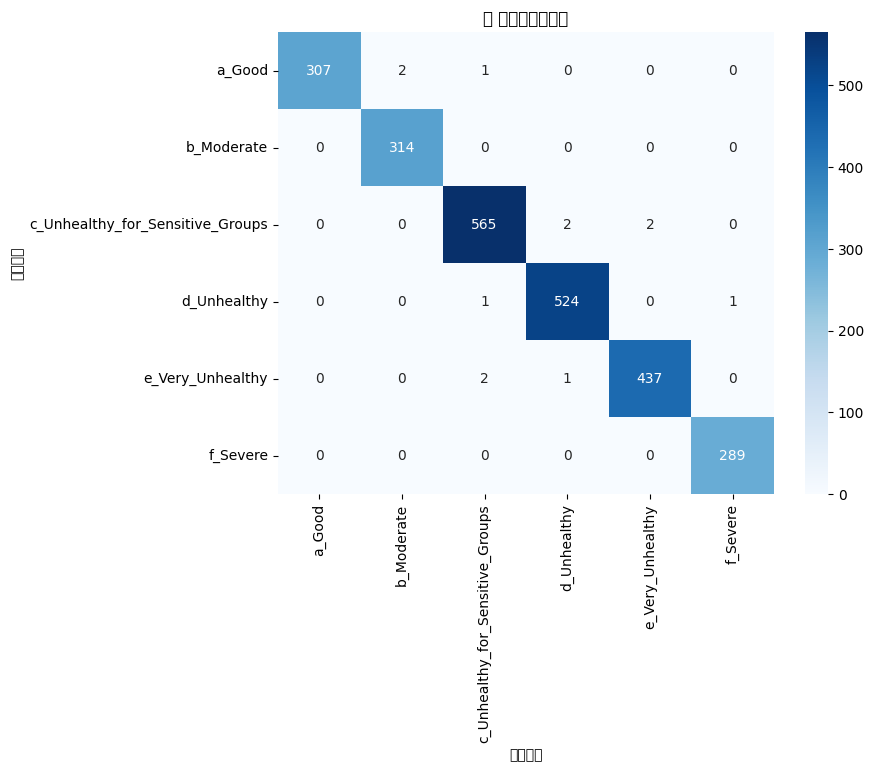

In [ ]:
# 測試集預測並產出 submission.csv
import numpy as np
import pandas as pd

model.eval()
all_probs = []

with torch.no_grad():
    for imgs, _ in test_loader:  # 測試集不使用標籤
        imgs = imgs.to(device)
        outs = model(imgs)
        probs = torch.softmax(outs, dim=1).cpu().numpy()
        all_probs.append(probs)

# 合併所有批次的預測結果
all_probs = np.vstack(all_probs)

# 對應類別欄位名稱
cols = ["a_Good", "b_Moderate", "c_Unhealthy_for_Sensitive_Groups",
        "d_Unhealthy", "e_Very_Unhealthy", "f_Severe"]

# 讀取測試集的原始檔名欄位
test_df = pd.read_csv(test_csv)  # 注意：test_csv 應為你之前設定的變數（含完整路徑）

# 建立提交檔案 DataFrame
submission = pd.DataFrame(all_probs, columns=cols)
submission.insert(0, "Filename", test_df["Filename"])

# 輸出 CSV 檔案
submission.to_csv("YU_submission.csv", index=False)
print("✅ YU_submission.csv 已產生，請前往 Kaggle 上傳")

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 用 all_probs 轉成預測類別 index
pred_labels = np.argmax(all_probs, axis=1)

# 對應 label 編碼
label2idx = {
    "a_Good": 0, "b_Moderate": 1, "c_Unhealthy_for_Sensitive_Groups": 2,
    "d_Unhealthy": 3, "e_Very_Unhealthy": 4, "f_Severe": 5
}
idx2label = {v: k for k, v in label2idx.items()}

# 讀入真實標籤
true_labels = test_df["AQI_Class"].map(label2idx).values

# 計算 accuracy
acc = accuracy_score(true_labels, pred_labels)
print(f"🎯 測試集準確率 (Accuracy): {acc:.4f}")

# Classification Report
print("\n📊 測試集分類表現：")
print(classification_report(true_labels, pred_labels, target_names=label2idx.keys()))

# 混淆矩陣
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label2idx.keys(), yticklabels=label2idx.keys())
plt.title("✅ 測試集混淆矩陣")
plt.xlabel("預測類別")
plt.ylabel("實際類別")
plt.show()




In [ ]:
from google.colab import files
files.download("YU_submission.csv")
#下載csv檔案
print("每一類預測平均機率：")
print(submission[cols].mean())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

每一類預測平均機率：
a_Good                              0.124563
b_Moderate                          0.130014
c_Unhealthy_for_Sensitive_Groups    0.231819
d_Unhealthy                         0.215337
e_Very_Unhealthy                    0.179530
f_Severe                            0.118733
dtype: float32


In [10]:
csv_path = "/content/drive/MyDrive/深度學習期末/archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv"
img_dir = "/content/drive/MyDrive/深度學習期末/archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img"

print("✅ IND_Nep_AQI_Dataset.csv 是否存在？", os.path.exists(csv_path))
print("✅ All_img 資料夾是否存在？", os.path.exists(img_dir))


✅ IND_Nep_AQI_Dataset.csv 是否存在？ True
✅ All_img 資料夾是否存在？ True


In [14]:
# 迴歸運算
# ✅ Step 1: 匯入套件與定義路徑
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models, transforms

# ✅ 檔案路徑
csv_path = "/content/drive/MyDrive/深度學習期末/archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv"
img_dir = "/content/drive/MyDrive/深度學習期末/archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img"

# ✅ Step 2: 定義 Dataset class
class AQIRegressionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=["AQI", "PM2.5", "Filename"])  # 移除缺失資料
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor([row["AQI"], row["PM2.5"]], dtype=torch.float32)
        return image, labels, row["Filename"]

# ✅ Step 3: 建立 Dataset 與 DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = AQIRegressionDataset(csv_file=csv_path, img_dir=img_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ✅ Step 4: 定義模型
class AQIRegressor(nn.Module):
    def __init__(self):
        super(AQIRegressor, self).__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 2)  # 輸出 AQI + PM2.5

    def forward(self, x):
        return self.backbone(x)

model = AQIRegressor().to("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Step 5: 訓練模型
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, labels, _ in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(train_loader):.4f}")

# ✅ Step 6: 測試預測並輸出成 csv
model.eval()
preds_list, true_list, fname_list = [], [], []

with torch.no_grad():
    for imgs, labels, fnames in train_loader:
        imgs = imgs.to(device)
        preds = model(imgs).cpu().numpy()
        labels = labels.numpy()
        preds_list.extend(preds)
        true_list.extend(labels)
        fname_list.extend(fnames)

preds_array = np.array(preds_list)
true_array = np.array(true_list)



[Epoch 1] Loss: 31660.1069
[Epoch 2] Loss: 19752.8195
[Epoch 3] Loss: 10950.9247
[Epoch 4] Loss: 6146.9061
[Epoch 5] Loss: 3567.2328
[Epoch 6] Loss: 2222.3457
[Epoch 7] Loss: 1445.1261
[Epoch 8] Loss: 1045.3015
[Epoch 9] Loss: 686.7166
[Epoch 10] Loss: 527.9442


In [15]:
# 計算 MAE, RMSE
mae = mean_absolute_error(true_array, preds_array)
mse = mean_squared_error(true_array, preds_array)
rmse = np.sqrt(mse)
print(f"\n🎯 MAE: {mae:.2f}, RMSE: {rmse:.2f}")


# 建立結果 DataFrame 並輸出 CSV
results_df = pd.DataFrame({
    "Filename": fname_list,
    "AQI_true": true_array[:, 0],
    "AQI_pred": preds_array[:, 0],
    "PM2.5_true": true_array[:, 1],
    "PM2.5_pred": preds_array[:, 1],
})

results_df.to_csv("YU_regression.csv", index=False)
print("✅ YU_regression.csv 已產生")

# 顯示下載連結（適用於 Colab）
from google.colab import files
files.download("YU_regression.csv")



🎯 MAE: 13.01, RMSE: 16.89
✅ YU_regression.csv 已產生


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>